## Classification d'articles de news
DIA Babacar Simplon 12/09/22

1.   Importation librairies

In [41]:
#importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string, os
import nltk
import re
import keras
import random
import io
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adamax
import sys
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image, ImageDraw, ImageFont
import warnings
warnings.filterwarnings("ignore")

2. Import du dataset



In [42]:
df = pd.read_csv (r'dataset\lyrics_clean.csv')
df.head()

,Lyric
0,"Wise men say, only fools rush in\nBut I can't ..."
1,Please allow me to introduce myself\nI'm a man...
2,"Back in black, I hit the sack,\nI've been too ..."
3,Parte1\nDaddy's flown across the ocean\nLeavin...
4,Someone told me long ago\nThere's a calm befor...


3.1. Dataset Shape





In [43]:
df.shape

(90, 1)

3.2. Check Information of Columns

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Lyric   90 non-null     object
dtypes: object(1)
memory usage: 848.0+ bytes


In [45]:
Corpus =''
for listitem in df.Lyric:
    Corpus += listitem

Corpus = Corpus.lower() #converting all alphabets to lowecase 
print("Number of unique characters:", len(set(Corpus)))

Number of unique characters: 59


In [46]:
import re

#To See all the unique characters present in the Corpus
print("The unique characters:",sorted(set(Corpus)))
Corpus = re.sub("[^A-Za-z0-9'\.\n]"," ",Corpus)

The unique characters: ['\n', ' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '[', ']', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ö', 'е', '‘', '…']


In [47]:
print("The unique characters:",sorted(set(Corpus)))

The unique characters: ['\n', ' ', "'", '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [48]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 104833
Number of unique characters: 40


In [49]:
#Splitting the Corpus in equal length of strings and output target
length = 20
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 104813


Encoding the Labels and Targets

In [50]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)

# one hot encode the output variable
y = np_utils.to_categorical(targets)

## MODEL BUILDING

In [51]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

#Model's Summary               
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               264192    
                                                                 
 dense_1 (Dense)             (None, 40)                10280     
                                                                 
Total params: 274,472
Trainable params: 274,472
Non-trainable params: 0
_________________________________________________________________


In [52]:
#Training the Model
history = model.fit(X, y, batch_size=128, epochs=5)

Epoch 1/5
819/819 [==============================] - 78s 92ms/step - loss: 2.8479
Epoch 2/5
819/819 [==============================] - 74s 91ms/step - loss: 2.6823
Epoch 3/5
819/819 [==============================] - 73s 90ms/step - loss: 2.5800
Epoch 4/5
819/819 [==============================] - 109s 133ms/step - loss: 2.4706
Epoch 5/5
819/819 [==============================] - 87s 106ms/step - loss: 2.3521


## EVALUATING MODELS

[Text(0.5, 0, 'Epochs')]

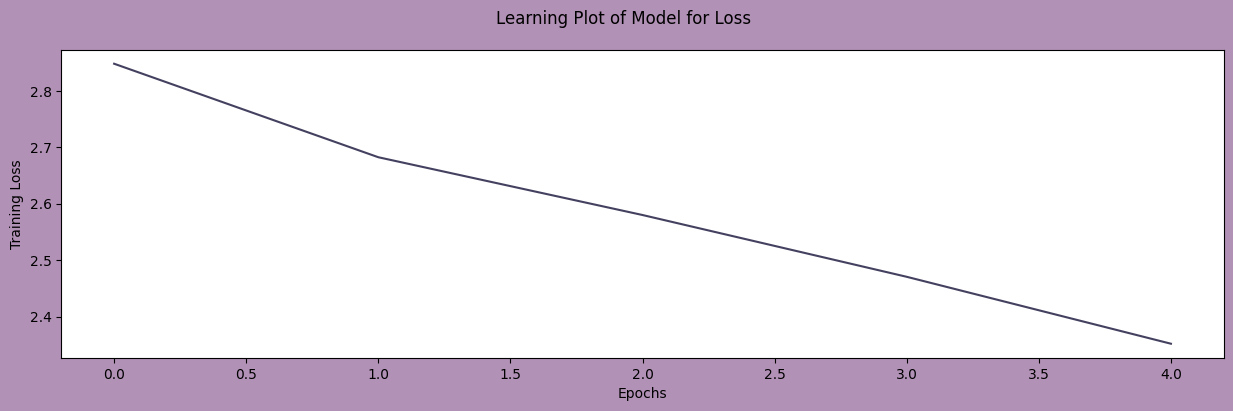

In [53]:
history_df = pd.DataFrame(history.history)
#Plotting the learnings 

fig = plt.figure(figsize=(15,4), facecolor="#B291B6")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

Generating the songs

In [54]:
# The function to generate text from model
def Lyrics_Generator(starter,Ch_count): #,temperature=1.0):
    generated= ""
    starter = starter 
    seed=[mapping[char] for char in starter]
    generated += starter 
    # Generating new text of given length
    for i in range(Ch_count):
        seed=[mapping[char] for char in starter]
        x_pred = np.reshape(seed, (1, len(seed), 1))
        x_pred = x_pred/ float(L_symb)
        prediction = model.predict(x_pred, verbose=0)[0]  
        # Getting the index of the next most probable index
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / 1.0 
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, prediction, 1)
        index = np.argmax(prediction)
        next_char = reverse_mapping[index]  
        # Generating new text
        generated += next_char
        starter = starter[1:] + next_char
       
    return generated

In [60]:
song_1 = Lyrics_Generator("love standing love  ", 100)

In [61]:
song_1

'love standing love  io soe thnl hn the wanl \nshe sesel sh the wanl \nsh you aadn \noot me to tee the saare\ntf the waare\n\ni'